In [9]:
import os
import sys
import time
import pandas as pd
import numpy as np
import pyBigWig
import tabix
import torch
from torch_fftconv import FFTConv1d
from torch import nn
from selene_sdk.targets import Target
import selene_sdk
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from matplotlib import pyplot as plt
import glob

In [2]:
tsses_hc  = pd.read_table('TSS_annotation.tsv', sep='\t')
genome = selene_sdk.sequences.Genome(
                    input_path='Homo_sapiens.GRCh38.dna.primary_assembly.fa',
                )
tsses_hc=tsses_hc.drop_duplicates(subset='geneName', keep='first')
tsses_hc.index=range(tsses_hc.shape[0])

In [3]:
##GRO Cap data GSE156829

import pyBigWig
import tabix
from selene_sdk.targets import Target
import numpy as np

class GenomicSignalFeatures(Target):
    def __init__(
        self,
        input_paths,
        features,

    ):

        self.input_paths = input_paths
        self.feature_index_dict = dict(
            [(feat, index) for index, feat in enumerate(features)]
        )

    def get_feature_data(
        self, chrom, start, end,  scale_factor=None ,nan_as_zero=True,
    ):
        self.data = [pyBigWig.open(path) for path in self.input_paths]
        feature_indices = np.arange(len(self.data))
        wigmat = np.zeros((len(feature_indices), end - start), dtype=np.float32)
        output=True
        for i in feature_indices:
            try:
                wigmat[i, :] = np.log2(self.data[i].values(chrom, start, end, numpy=True)/100+1)
            except:
                print(chrom, start, end, self.input_paths[i], flush=True)
                output=False
                


        if nan_as_zero:
            wigmat[np.isnan(wigmat)] = 0

        return wigmat,output

tfeature = GenomicSignalFeatures(["./PD23_PROCAPAligned.sortedByCoord.out_reverse.bw",
"./PD76_PROCAPAligned.sortedByCoord.out_reverse.bw",
"./PD76_PROCAPAligned.sortedByCoord.out_forward.bw",
"./PD23_PROCAPAligned.sortedByCoord.out_forward.bw"                                 
                                ],
                               ["P_forward",
                                 "S_forward",
                                 "S_reverse",
                                "P_reverse"
                                 ]
                               )


In [5]:
window_size = 4650
seqs = []
tars = []

for randi in range(tsses_hc.shape[0]):
    chrom=tsses_hc["chr"].values[randi]
    strand=tsses_hc["strand"].values[randi] 
    start=tsses_hc["TSS"].values[randi]
    offset = 1 if strand == "-" else 0
    seq = genome.get_encoding_from_coords(chrom,start- window_size // 2 + offset,start+ window_size // 2 + offset ,strand)
    tar,tar_out = tfeature.get_feature_data(chrom,start- window_size // 2 + offset,start+ window_size // 2 + offset)

    if tar_out ==True:
        if strand == "-":
            tar = tar[::-1, ::-1]
        seqs.append(seq)
        tars.append(tar)


seqs = np.dstack(seqs)
tars = np.dstack(tars)
seqs = seqs.transpose([2, 1, 0])
tars = tars.transpose([2, 0, 1])


In [6]:
np.random.seed(1)
randinds = np.random.permutation(np.arange(tsses_hc.shape[0]))
seqs_rand = seqs[randinds, :]
tars_rand = tars[randinds, :]
tsses_hc_rand = tsses_hc.iloc[randinds, :]
train_seqs = seqs_rand[~tsses_hc_rand["chr"].isin(["chr8", "chr9", "chr10"]).values, :]
valid_seqs = seqs_rand[tsses_hc_rand["chr"].isin(["chr8", "chr9", "chr10"]).values, :]

train_tars = tars_rand[~tsses_hc_rand["chr"].isin(["chr8", "chr9", "chr10"]).values, :]
valid_tars = tars_rand[tsses_hc_rand["chr"].isin(["chr8", "chr9", "chr10"]).values, :]


tsses_hc_rand_train=tsses_hc_rand.iloc[~tsses_hc_rand["chr"].isin(["chr8", "chr9", "chr10"]).values, :]
tsses_hc_rand_valid=tsses_hc_rand.iloc[tsses_hc_rand["chr"].isin(["chr8", "chr9", "chr10"]).values, :]

print(train_tars.shape)



(34771, 4, 4650)


In [10]:

class SimpleNet(nn.Module):
    def __init__(self):

        super(SimpleNet, self).__init__()
        self.conv = nn.Conv1d(4, 40, kernel_size=51, padding=25)
        self.conv_inr = nn.Conv1d(4, 10, kernel_size=15, padding=7)
        self.activation = nn.ReLU()
        self.deconv = FFTConv1d(80, 4, kernel_size=601, padding=300)
        self.deconv_inr = nn.ConvTranspose1d(20, 4, kernel_size=15, padding=7)
        self.softplus = nn.Softplus()

    def forward(self, x):
        y = torch.cat([self.conv(x), self.conv(x.flip([1, 2])).flip([2])], 1)
        y_inr = torch.cat(
            [self.conv_inr(x), self.conv_inr(x.flip([1, 2])).flip([2])], 1
        )
        yact = self.activation(y) * y
        y_inr_act = self.activation(y_inr) * y_inr

        y_pred = self.softplus(self.deconv(yact) + self.deconv_inr(y_inr_act))

        
        return y_pred


net = SimpleNet()

fs=glob.glob("SenNet_TSS.pth")
net.load_state_dict(torch.load(fs[0]))

net.cpu()
net.eval()

SimpleNet(
  (conv): Conv1d(4, 40, kernel_size=(51,), stride=(1,), padding=(25,))
  (conv_inr): Conv1d(4, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (activation): ReLU()
  (deconv): FFTConv1d(80, 4, kernel_size=(601,), stride=(1,), padding=(300,))
  (deconv_inr): ConvTranspose1d(20, 4, kernel_size=(15,), stride=(1,), padding=(7,))
  (softplus): Softplus(beta=1, threshold=20)
)

In [11]:
class Batcher:
    """
    Class used to automatically batch the model prediction
    because it is often easier to write single input code code,
    but model execution is much faster when batched.
    
    With Batcher, the output is delayed until the cache is filled to
    reach the specified batch size, then the batch output is appended to
    output_list. Remember to execute the last batch remaining in cache
    with`run`.
    """
    def __init__(self, net, batchsize, numpy_output=True):
        self.batchsize = batchsize
        self.net = net
        self.counter = 0
        self.numpy_output = numpy_output
        self.cache = []
        
    def __call__(self, x, output_list):
        if self.counter + x.shape[0] > self.batchsize:
            self.cache.append(x)
            self.run(output_list)
        else:
            self.cache.append(x)
            self.counter += x.shape[0]
    
    def run(self, output_list):
        batch = torch.cat(self.cache, 0)
        if self.numpy_output:
            output_list.append(self.net(batch).detach().cpu().numpy())
        else:
            output_list.append(self.net(batch))
        self.cache = []
        self.counter = 0
        


In [12]:
half_window = 500
half_window_p = half_window+325
tss_preds = []

def KL(pred, target):
    pred = (pred+1e-10) / ((pred+1e-10).sum(2)[:,:,None])
    target = (target+1e-10) / ((target+1e-10) .sum(2)[:,:,None])
    return target * (torch.log(target+1e-10) - torch.log(pred+1e-10))

batcher = Batcher(net, 512)
tss_preds = []
net.eval()
for tssi in range(tsses_hc.shape[0]):
    if tssi%100==0:
        print(tssi)
    chrm, pos, strand = tsses_hc['chr'][tssi], tsses_hc['TSS'][tssi], tsses_hc['strand'][tssi]
    offset = 1 if strand == '-' else 0

    seq = genome.get_encoding_from_coords(chrm, pos-half_window_p+offset, pos+half_window_p+offset, strand)
    #net.cuda()
    seqcuda = torch.FloatTensor(seq.copy())[None,:,:].transpose(1,2)#.cuda()
    batcher(seqcuda, tss_preds)

batcher.run(tss_preds)

tss_preds = np.concatenate(tss_preds)[:,:,325:-325]


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [13]:
tss_targets = []
for tssi in range(tsses_hc.shape[0]):
    chrm, pos, strand = tsses_hc['chr'][tssi], tsses_hc['TSS'][tssi], tsses_hc['strand'][tssi]
    offset = 1 if strand == '-' else 0
    target,tar_out = tfeature.get_feature_data(chrm, pos-half_window_p+offset, pos+half_window_p+offset)
    if strand == '-':
      target = target[::-1, ::-1].copy()
    tss_targets.append(target[None,:,300:-300])
tss_targets = np.concatenate(tss_targets)


In [14]:
from scipy.stats import pearsonr
cors = []
for i in range(tss_preds.shape[0]):
    if i%1000==0:
        print(i)
    c=(pearsonr(tss_preds[i,0,:],tss_targets[i,0,25:-25])[0]+pearsonr(tss_preds[i,1,:],tss_targets[i,1,25:-25])[0])/2
    cors.append(c)

tss_targetsums20 = (2**tss_targets[:,:,500-20:500+20]-1).sum(axis=2)


filterinds=tsses_hc[tsses_hc["chr"].isin(["chr8","chr9","chr10"])].index.values

bins =   [-np.inf]+list(np.arange(0, 1, 0.2)) + [np.inf]
log_expr = np.log2((tss_targetsums20[filterinds, 0]+tss_targetsums20[filterinds, 1])/2+1)
chunks = pd.cut(log_expr, bins=bins)

df_plot = pd.DataFrame({
    'correlation': np.array(cors)[filterinds],   # x-axis data
    'expression_level': chunks                     # y-axis categorical data
})

df_plot['expression_level'] = df_plot['expression_level'].cat.reorder_categories(
    df_plot['expression_level'].cat.categories[::-1],
    ordered=True
)


0


/tmp/ipykernel_32696/3573863739.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  c=(pearsonr(tss_preds[i,0,:],tss_targets[i,0,25:-25])[0]+pearsonr(tss_preds[i,1,:],tss_targets[i,1,25:-25])[0])/2


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000


NameError: name 'joypy' is not defined

<Figure size 800x600 with 0 Axes>

/work/CRI/s211066/package/Anaconda/envs/sei3/lib/python3.9/site-packages/joypy/joyplot.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)


<Figure size 800x600 with 0 Axes>

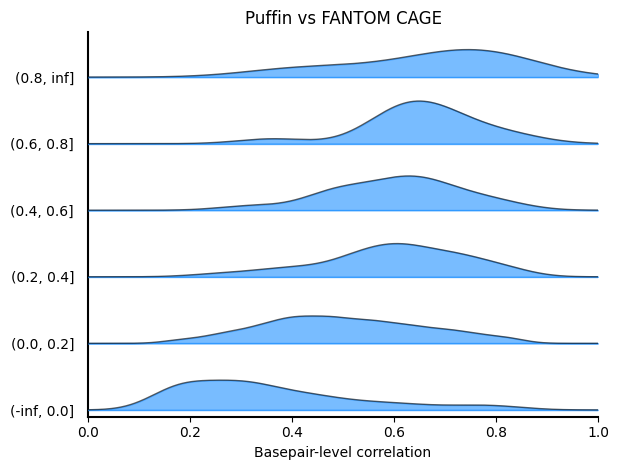

In [16]:

import joypy 
plt.figure(figsize=(8, 6))
joypy.joyplot(df_plot, by='expression_level', column='correlation', 
              color="#1E90FF", alpha=0.6, linewidth=1)

plt.xlim(0, 1)
plt.xlabel('Basepair-level correlation')
plt.ylabel('Expression level (log10)')
plt.title('Puffin vs FANTOM CAGE')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Optional: Make the x and y axis lines thicker or colored
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color("black")
ax.spines['bottom'].set_color("black")

plt.tight_layout()

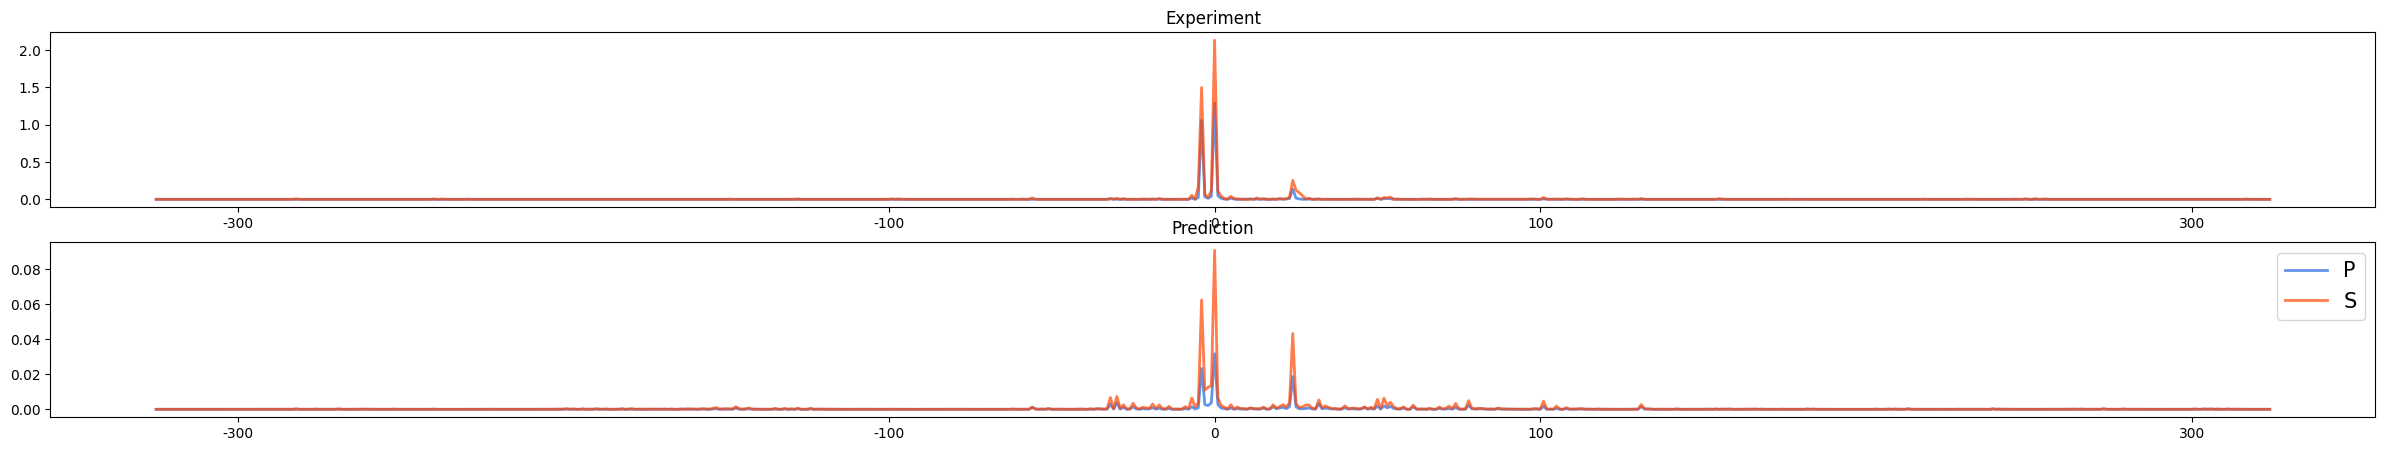

In [15]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,5))

halfwindow=325
axes[0].plot(range(-halfwindow,halfwindow),tars[147,0,2000:-2000].T,linewidth=2,alpha=1,c="#6495ED")
axes[0].plot(range(-halfwindow,halfwindow),tars[147,1,2000:-2000].T,linewidth=2,alpha=0.7,c="#FF4500")
axes[0].set_title("Experiment")

net.eval()
pred = net(torch.Tensor(seqs[147:149]))
axes[1].plot(range(-halfwindow,halfwindow),pred.cpu().detach().numpy()[0,0,2000:-2000],linewidth=2,alpha=1,c="#6495ED",label="P")
axes[1].plot(range(-halfwindow,halfwindow),pred.cpu().detach().numpy()[0,1,2000:-2000],linewidth=2,alpha=0.7,c="#FF4500",label="S")
axes[1].set_title("Prediction")
axes[1].legend(loc='upper right',fontsize=15)


axes[0].grid(False) 
axes[1].grid(False) 

xticks = [-300,-100,0,100,300]
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xticks)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xticks)

plt.rcParams['pdf.fonttype'] = 42


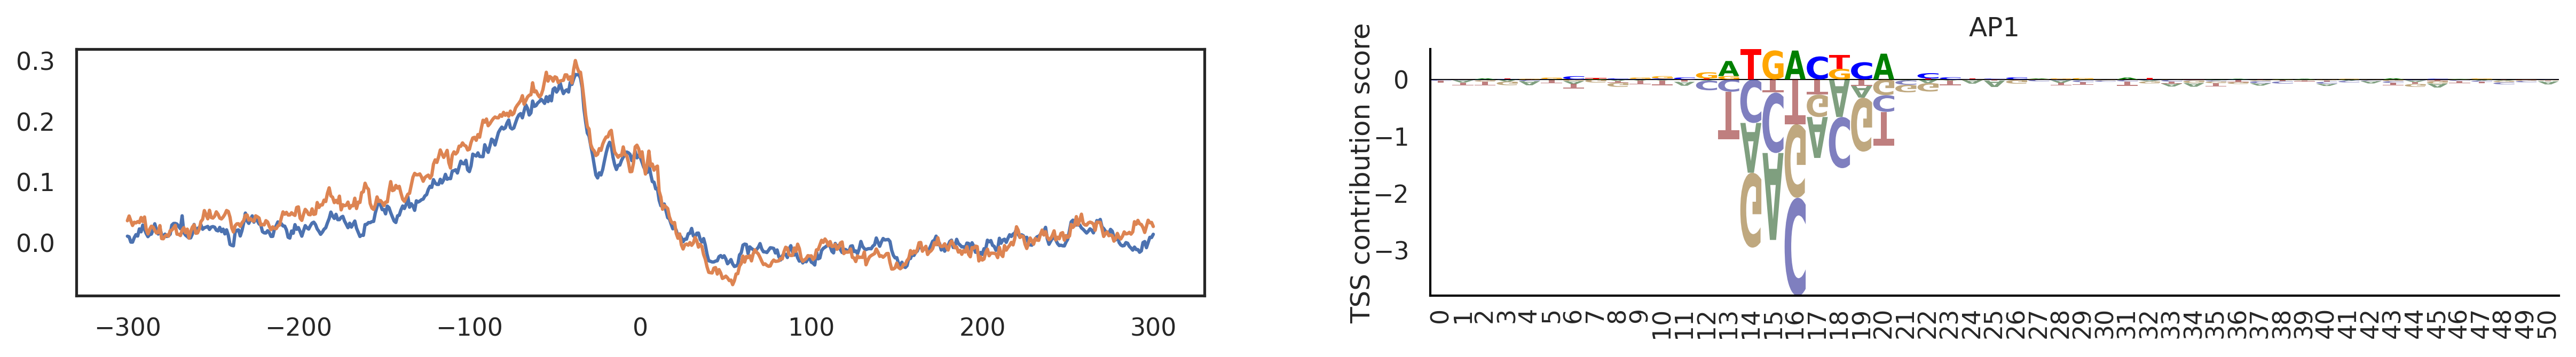

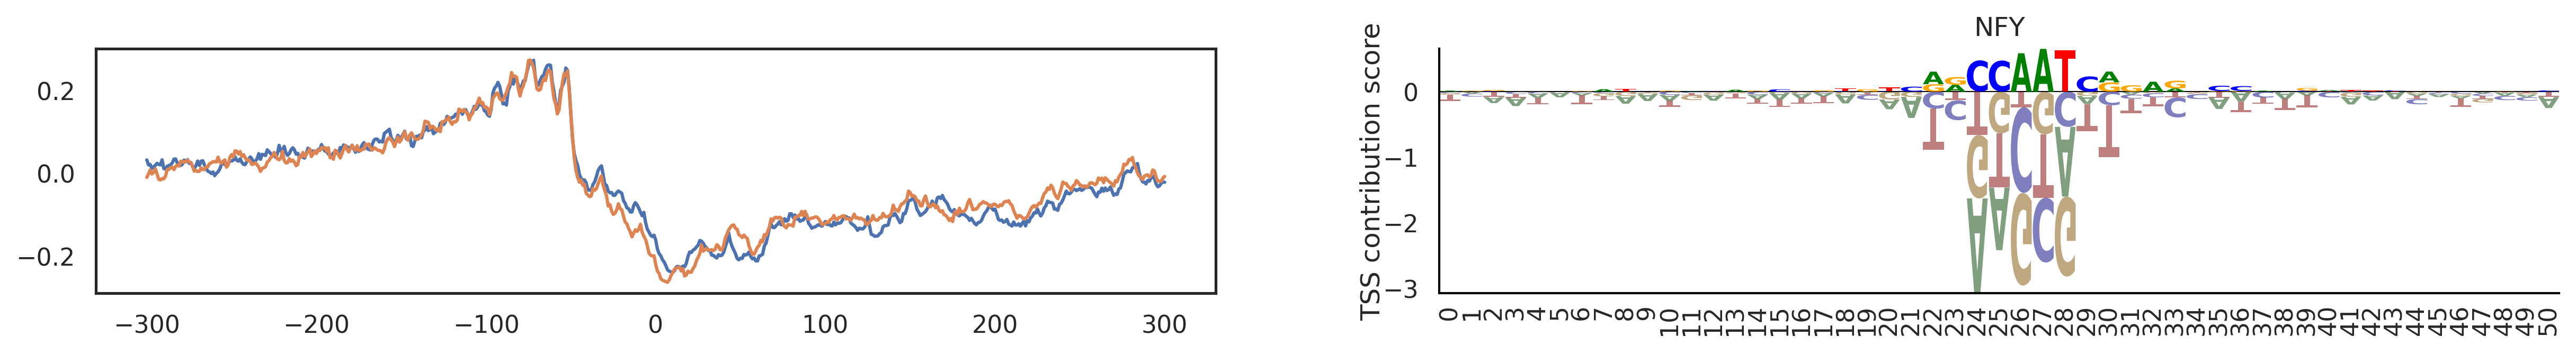

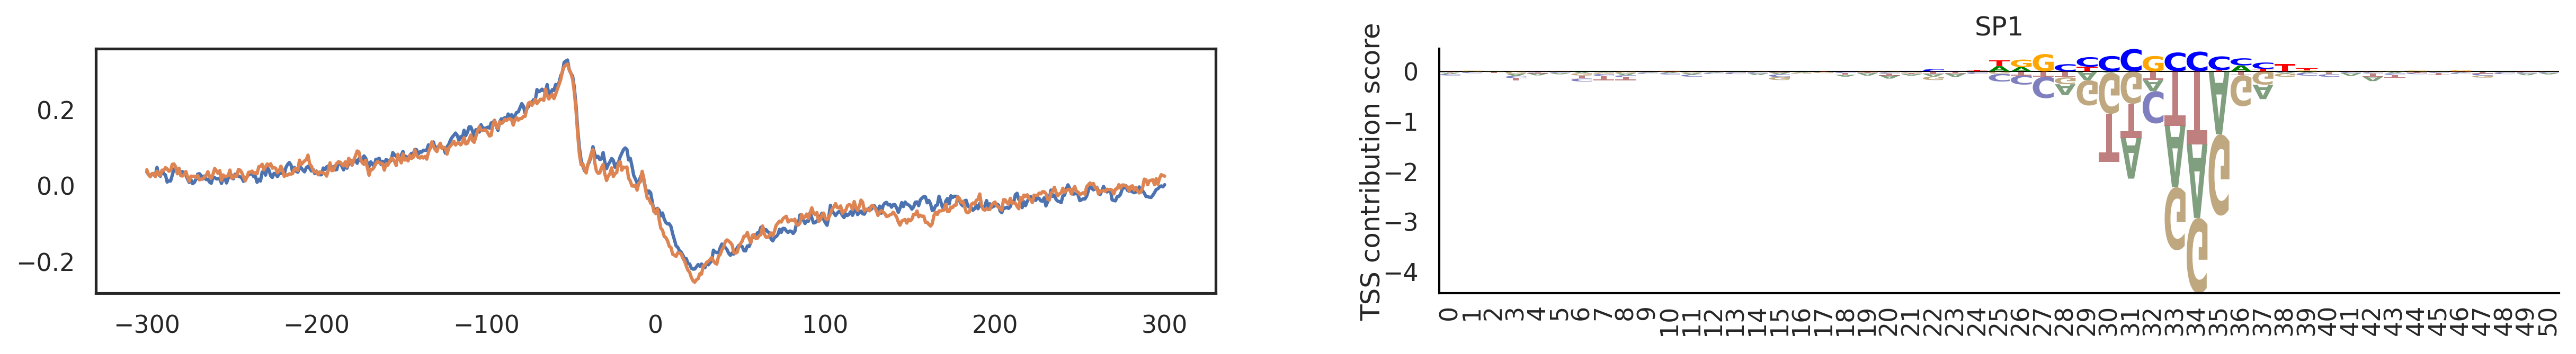

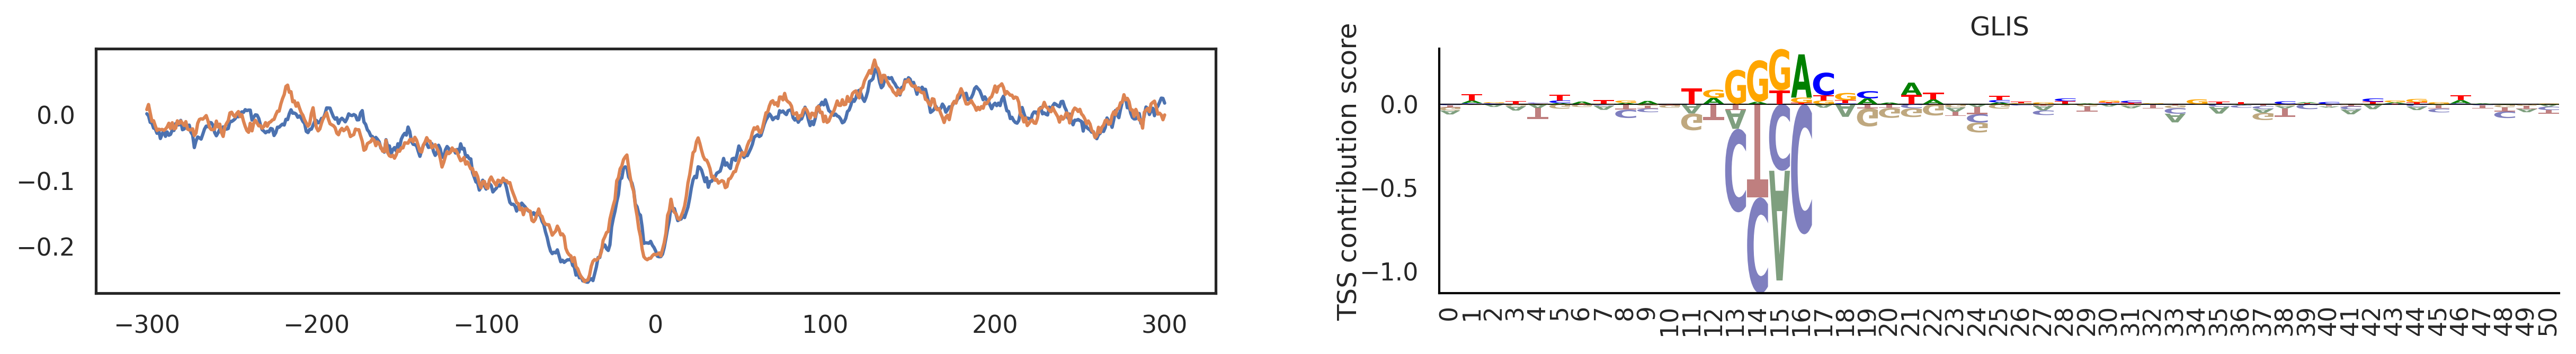

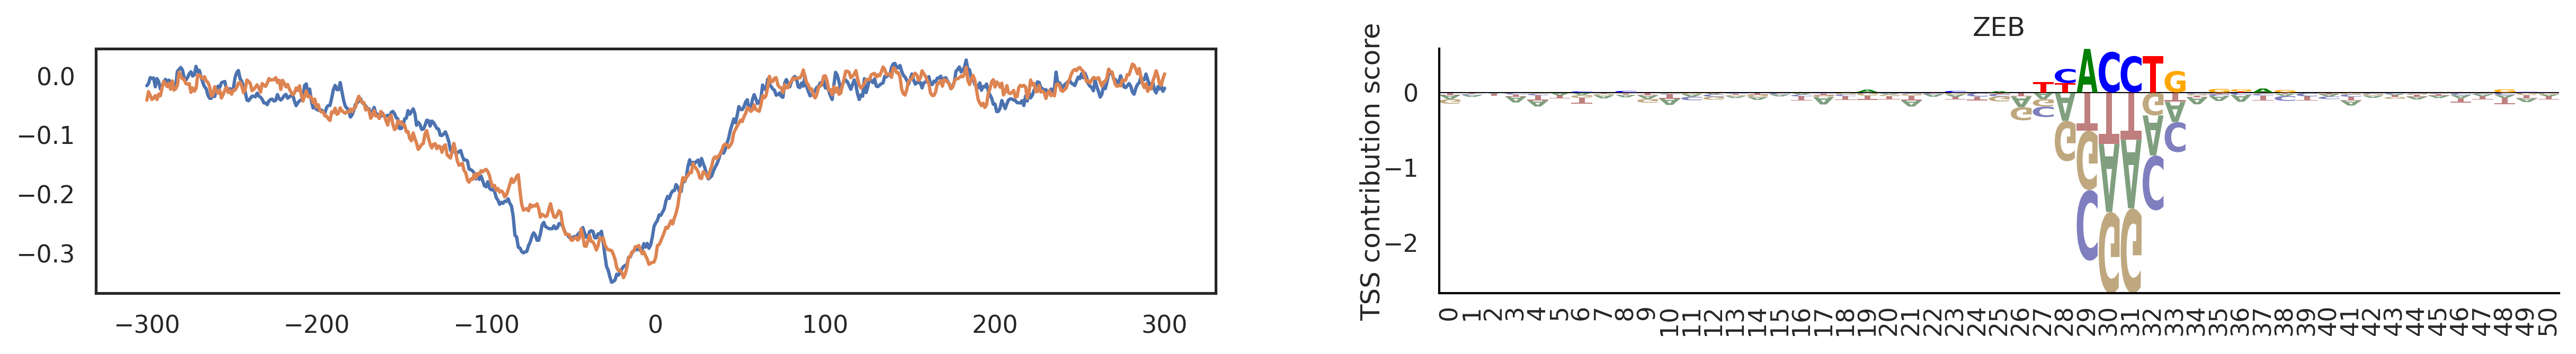

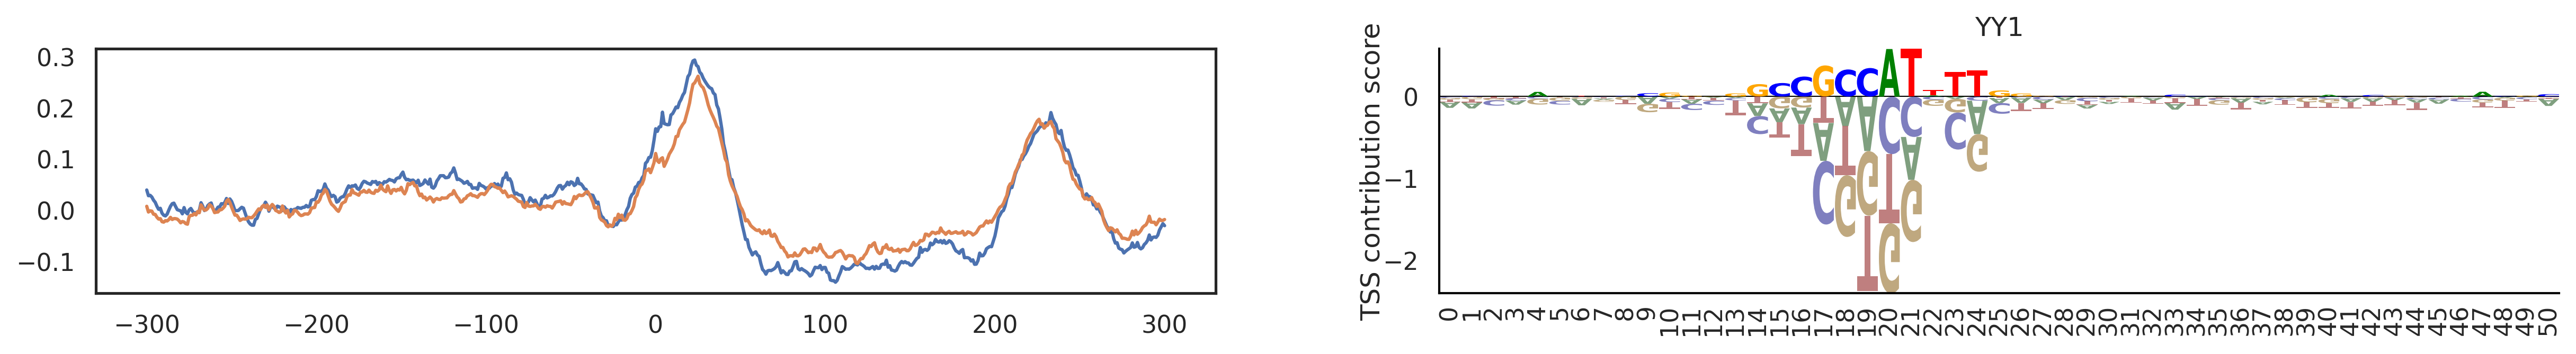

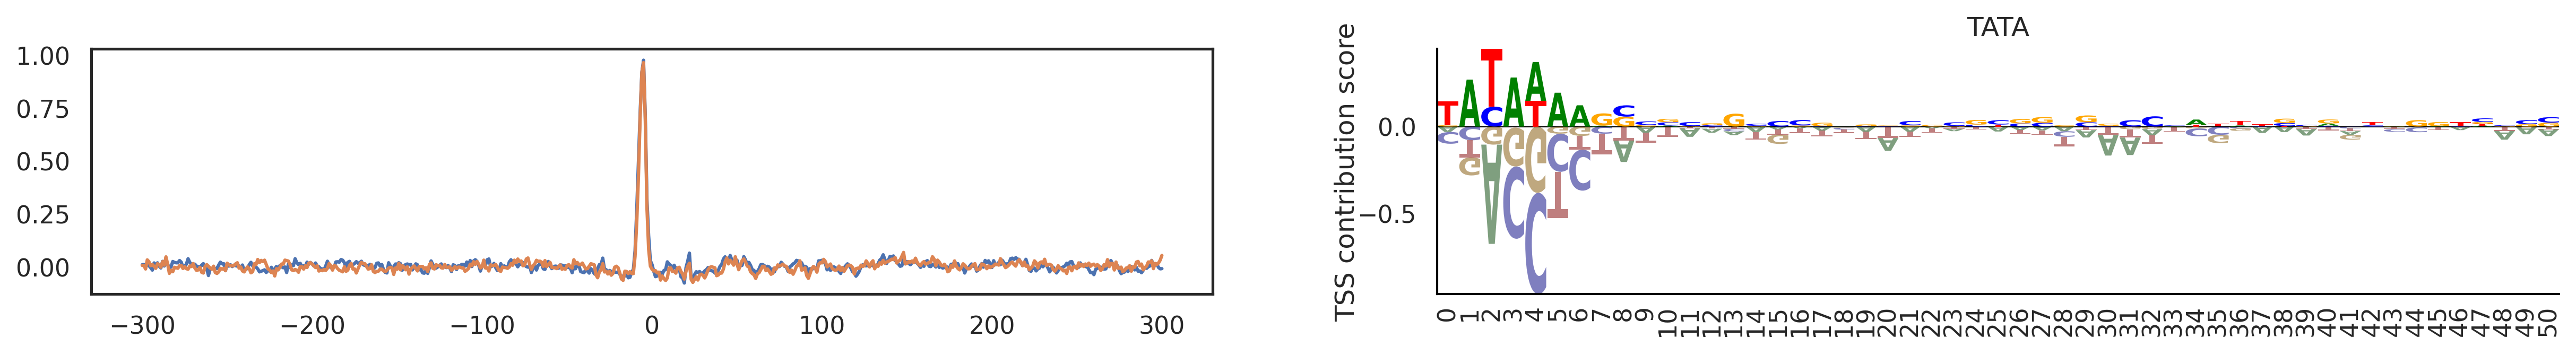

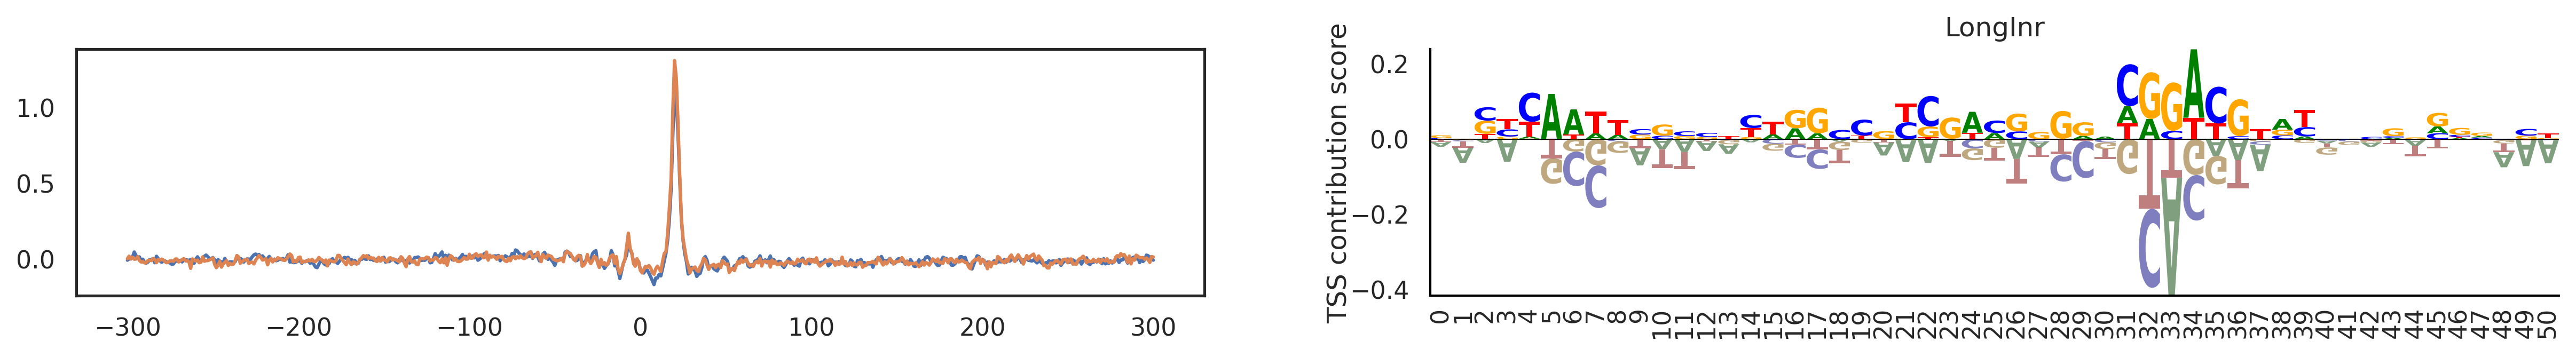

In [19]:
##Take a look of motif 
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style("white")

import logomaker
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
prop_cycle = plt.rcParams['axes.prop_cycle']
itercolor =  prop_cycle()
def plotfun(motifpwm, title=None, ax=None):
    motifpwm = pd.DataFrame(motifpwm,columns=['A','C','G','T'])
    crp_logo = logomaker.Logo(motifpwm,
                              shade_below=.5,
                              fade_below=.5,
                              # font_name='Arial Rounded MT Bold',
                             ax=ax)

    # style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
    if title is not None:
        crp_logo.ax.set_title(title)
    # style using Axes methods
    crp_logo.ax.set_ylabel("TSS contribution score", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
    return crp_logo

weight = net.deconv.weight[:,:,:].cpu().detach().numpy()

pwm = net.conv.weight[:,:,:].cpu().detach().numpy()

Motif_index={45:"AP1",7:"NFY",16:"SP1",24:"GLIS",19:"ZEB",20:"YY1", 39:"TATA",9:"LongInr"}


for i in Motif_index.keys():
    fig, axes = plt.subplots(1, 2, figsize=(20,2))
    axes[0].plot(np.arange(-300,301), weight[0,i,:].T)
    axes[0].plot(np.arange(-300,301), weight[1,i,:].T)
    if i>40:       
        plotfun(pwm[i % 40][::-1,::-1].T,title=Motif_index[i] , ax=axes[1])
    else:
        plotfun(pwm[i % 40].T,title=Motif_index[i] , ax=axes[1])

In [20]:
mm10= selene_sdk.sequences.Genome(
                input_path='mm10.fa'
            )

In [22]:
import re
Repeat=pd.read_csv("mm10_rmsk_TE_location.bed",sep="\t",header=None)
Repeat["ID"]=Repeat[4].str.split(pat=".",expand=True)[0]
Repeat["length"]=Repeat[2]-Repeat[1]
RA=Repeat.loc[Repeat["ID"]=="RLTR6_Mm"]
RB=Repeat.loc[Repeat["ID"]=="RLTR6B_Mm"]
RC=Repeat.loc[Repeat["ID"]=="RLTR6C_Mm"]
RT=Repeat.loc[Repeat["ID"]=="RLTR6-int"]
ML30=Repeat.loc[Repeat["ID"]=="MMVL30-int"]
RABC=pd.concat([RA,RB,RC])
R_FL=pd.read_csv("ML30RT_FullLength.bed",sep="\t",header=None)
R_promoter=[[R_FL.iloc[i,3],R_FL.iloc[i,6]] if R_FL.iloc[i,5]=="+" else [R_FL.iloc[i,3],R_FL.iloc[i,7]] for i in range(R_FL.shape[0])]
R_promoter=[i for i in R_promoter if not re.search("int",i[1]) ]

In [23]:
##Cluster to DEG
Etoposide_LR=pd.read_csv("LongRead_FC.txt",sep="\t",index_col=0)
Etoposide_SR_TimeS=pd.read_csv("Individial_TE_timeseries_UniqueQuantify_correlation_combineFullLength.txt",sep="\t",index_col=0)
Etoposide_SR_TimeS=Etoposide_SR_TimeS.loc[Etoposide_SR_TimeS.index.str.contains("_FL")]
Etoposide_SR_FC=pd.read_csv("Individial_TE_Eto_UniqueQuantify_FC_combineFullLength.txt",sep="\t",index_col=0)
Etoposide_SR_FC=Etoposide_SR_FC.loc[Etoposide_SR_FC.index.str.contains("_FL")]
Etoposide_SR_FC_sign=Etoposide_SR_FC[(Etoposide_SR_FC["padj"]<0.05) & (Etoposide_SR_FC["log2FoldChange"] >0.5)]
Etoposide_SR_TimeS_sign=Etoposide_SR_TimeS[(Etoposide_SR_TimeS["pvalue"]<0.05) & (Etoposide_SR_TimeS["corr"] >0)]

Etoposide_LR_sign=[j for i,j in R_promoter if i in Etoposide_LR[Etoposide_LR["log2FC"]>0.8].index.values]
Etoposide_SR_FC_sign=[j for i,j in R_promoter if i in Etoposide_SR_FC_sign.index.values]
Etoposide_SR_TimeS_sign=[j for i,j in R_promoter if i in Etoposide_SR_TimeS_sign.index.values]


In [24]:
Etoposide_SR_FC_data=pd.merge(pd.DataFrame(R_promoter),Etoposide_SR_FC.reset_index(), left_on=0, right_on='index', how='left')
Etoposide_SR_FC_data["log2FoldChange"]=Etoposide_SR_FC_data["log2FoldChange"].fillna(0)
Etoposide_SR_FC_data=pd.merge(Etoposide_SR_FC_data,RABC,left_on=1, right_on=5, how='left')
Etoposide_SR_FC_data=pd.merge(Etoposide_SR_FC_data,Etoposide_SR_TimeS["corr"].reset_index(),left_on="0_x", right_on='index', how='left')
Etoposide_SR_FC_data["corr"]=Etoposide_SR_FC_data["corr"].fillna(0)

In [26]:
net.cuda()
R_promoter_TSSsignal={}
for FL,R_i in R_promoter:
    chrom=RABC[RABC[5]==R_i].values[0][0]
    start=int(RABC[RABC[5]==R_i].values[0][1])
    end=int(RABC[RABC[5]==R_i].values[0][2])
    strand=RABC[RABC[5]==R_i].values[0][3]
    
    seq=mm10.get_encoding_from_coords(chrom, start-500, end+500,strand)
    preact_motif = torch.cat([net.conv(torch.FloatTensor(seq)[None,:,:].transpose(1,2).cuda()), \
                       net.conv(torch.FloatTensor(seq)[None,:,:].transpose(1,2).flip([1,2]).cuda()).flip([2])], 1)
    postact_motif = net.activation(preact_motif)
    postact_motif = postact_motif.cpu().detach().numpy()
    with torch.no_grad():
        pred = net(torch.FloatTensor(seq)[None,:,:].transpose(1,2).cuda()).cpu().detach().numpy()[...,500:-500]
    effects_motifs_all = []
    for targeti in range(4):
        effects_motifs = []    
        for i in range(80):
            effects_motif = np.convolve(postact_motif[0,i,:], net.deconv.weight.cpu().detach().numpy()[targeti,i,::-1], mode='same')
            effects_motifs.append(effects_motif)
        effects_motifs_all.append(effects_motifs)
    effects_motifs_all=np.array(effects_motifs_all)

    R_promoter_TSSsignal[R_i]=[pred,postact_motif[...,500:-500],effects_motifs_all[...,500:-500]]    

In [27]:
from Bio.motifs import jaspar
from Bio import SeqIO
import seaborn as sns

In [28]:
#Draw the signal by position 
trees=glob.glob("RABC.phylotree")
trees
trees_i=0
ranklist=[]
for line in open(trees[trees_i],"r"):
    if re.search("^R",line):
       ranklist.append(line.split(":")[0]) 
    
clusts=glob.glob("RABC.fa")
clusts

clusts_i=trees_i
clust=SeqIO.to_dict(SeqIO.parse(clusts[clusts_i], "fasta"))
print(clusts[clusts_i])
k2v={}
for k,v in clust.items():
    k2v[k]=list(str(v.seq))
#     print(len(v.seq))
# ranklist=ranklist[40:]+ranklist[:40]

ranklist_FC=[]
A= [i for i in ranklist if i.split("_dup")[0] =="RLTR6_Mm"]
A=np.array(A)[np.array([Etoposide_SR_FC_data[Etoposide_SR_FC_data[1]==i]["log2FoldChange"].values[0] for i in ranklist if i in A]).argsort()]
ranklist_FC=ranklist_FC+list(A[::-1])
A= [i for i in ranklist if i.split("_dup")[0] =="RLTR6C_Mm"]
A=np.array(A)[np.array([Etoposide_SR_FC_data[Etoposide_SR_FC_data[1]==i]["log2FoldChange"].values[0] for i in ranklist if i in A]).argsort()]
ranklist_FC=ranklist_FC+list(A[::-1])
A= [i for i in ranklist if i.split("_dup")[0] =="RLTR6B_Mm"]
A=np.array(A)[np.array([Etoposide_SR_FC_data[Etoposide_SR_FC_data[1]==i]["log2FoldChange"].values[0] for i in ranklist if i in A]).argsort()]
ranklist_FC=ranklist_FC+list(A[::-1])
 

RABC.fa


/tmp/ipykernel_32696/1664623485.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  k2v_MapValue.replace('na', np.nan, inplace=True)


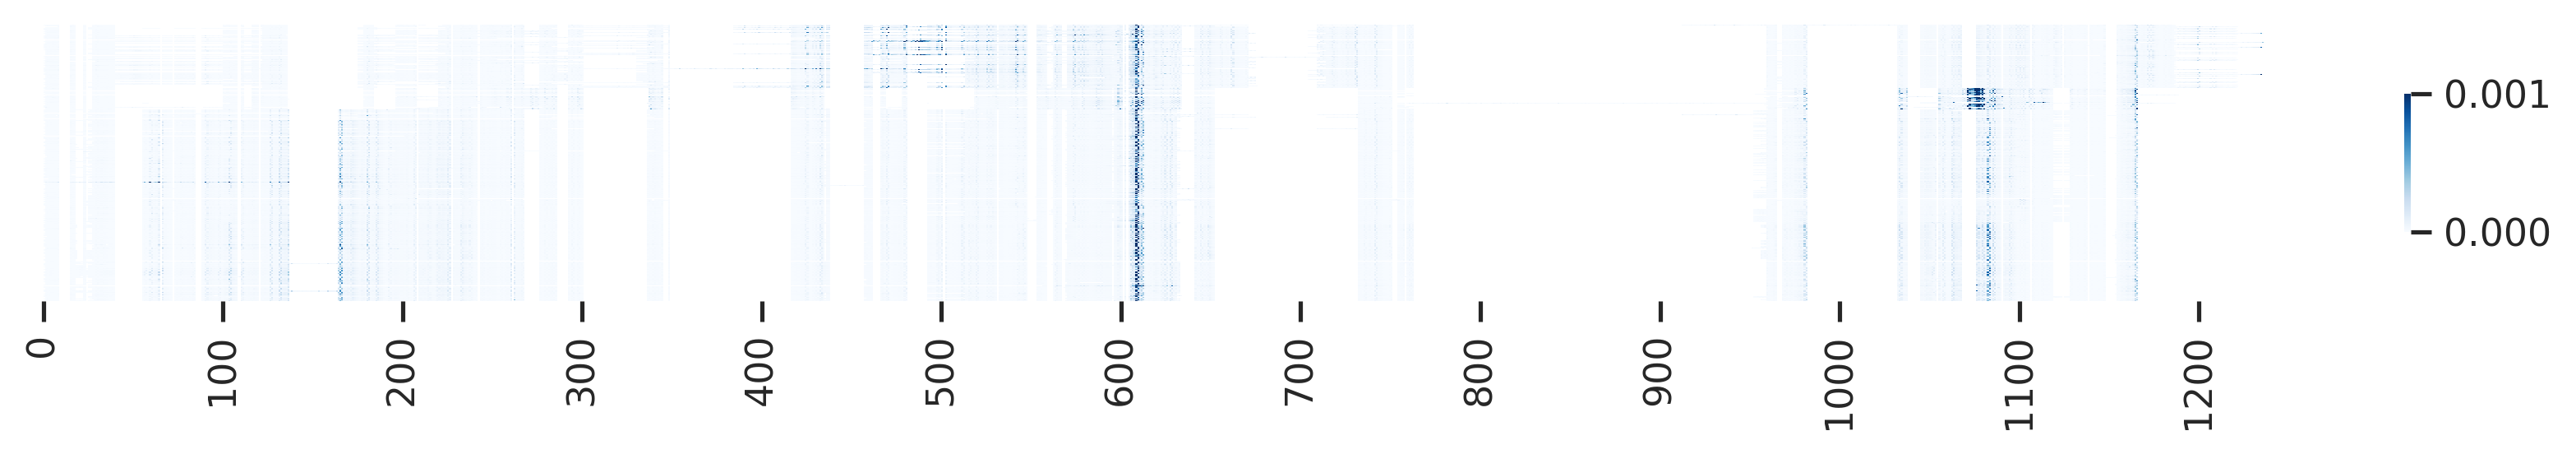

In [29]:

k2v_MapValue={}
for k in list(k2v.keys()):
    map_value=[]
    i=0
    v=R_promoter_TSSsignal[k][0][:,0,:][0]
    # v=v/v.max()
    for a in k2v[k]:
        if a == "-":
            map_value.append("na")
        else:
            if i <len(v):
                map_value.append(v[i])
                i=i+1
            else:
                map_value.append(0)
                i=i+1       
    k2v_MapValue[k]=map_value
    # TSS_P.append()
k2v_MapValue=pd.DataFrame.from_dict(k2v_MapValue)
k2v_MapValue.replace('na', np.nan, inplace=True)
k2v_MapValue=k2v_MapValue[ranklist_FC]
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 2)
ax=sns.heatmap(k2v_MapValue.T, cmap="Blues", vmin=0,vmax=0.001,cbar_kws={'shrink': 0.5}, rasterized=True,xticklabels=True, yticklabels=False)##plt.tight_layout()


xticks = list(range(0, k2v_MapValue.T.shape[1], 100))
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)


ax.collections[0].cmap.set_bad('white')
plt.rcParams['pdf.fonttype'] = 42
plt.tight_layout()

TSS_P=k2v_MapValue.T#.iloc[:,605:614].sum(1)


/tmp/ipykernel_32696/735092637.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  k2v_MapValue.replace('na', np.nan, inplace=True)


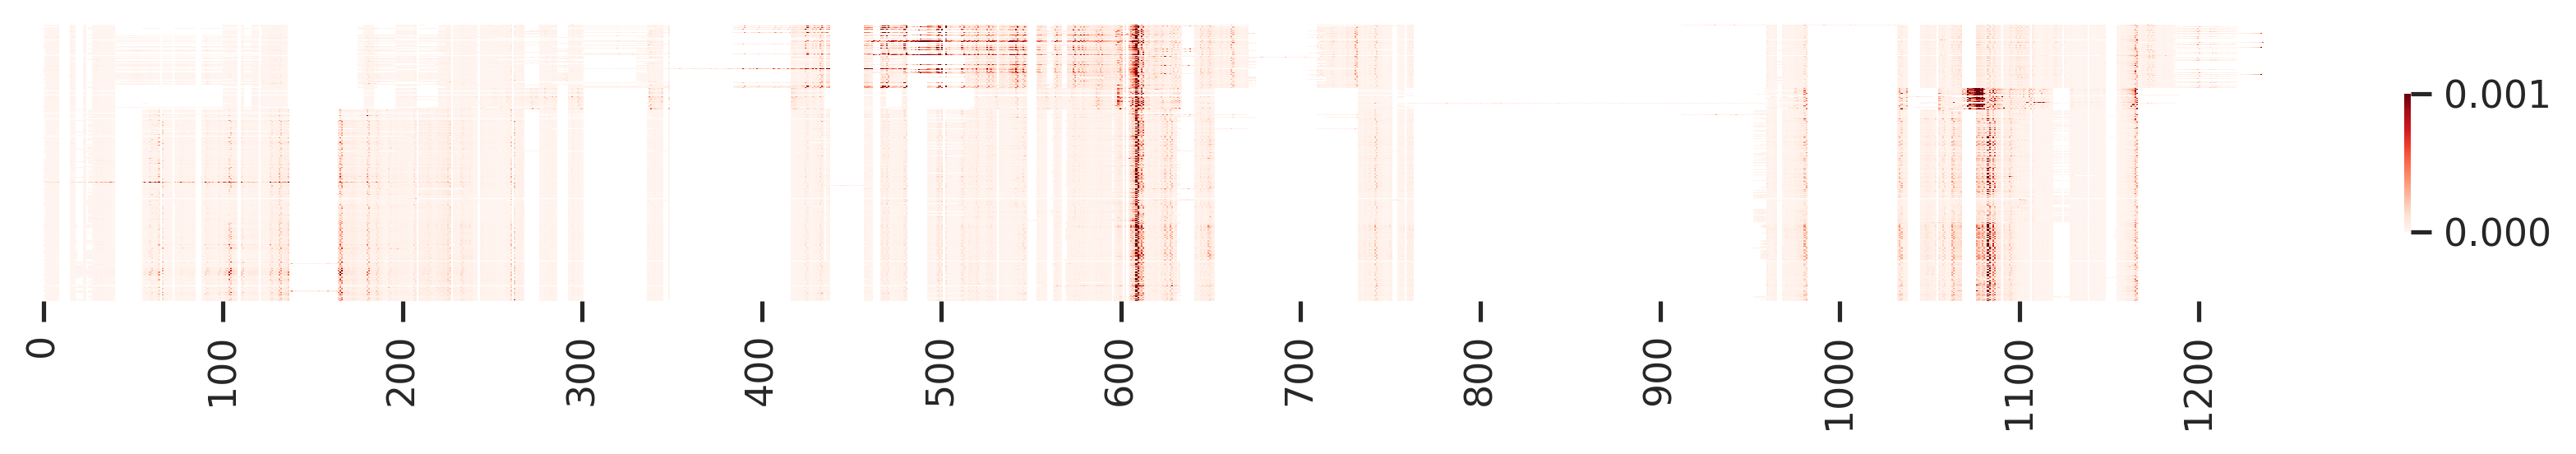

In [30]:

k2v_MapValue={}
for k in list(k2v.keys()):
    map_value=[]
    i=0
    v=R_promoter_TSSsignal[k][0][:,1,:][0]
    # v=v/v.max()
    for a in k2v[k]:
        if a == "-":
            map_value.append("na")
        else:
            if i <len(v):
                map_value.append(v[i])
                i=i+1
            else:
                map_value.append(0)
                i=i+1       
    k2v_MapValue[k]=map_value
    # TSS_P.append()
k2v_MapValue=pd.DataFrame.from_dict(k2v_MapValue)
k2v_MapValue.replace('na', np.nan, inplace=True)
k2v_MapValue=k2v_MapValue[ranklist_FC]
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 2)
ax=sns.heatmap(k2v_MapValue.T, cmap="Reds", vmin=0,vmax=0.001,cbar_kws={'shrink': 0.5}, rasterized=True,xticklabels=True, yticklabels=False)##plt.tight_layout()


xticks = list(range(0, k2v_MapValue.T.shape[1], 100))
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)


ax.collections[0].cmap.set_bad('white')
plt.rcParams['pdf.fonttype'] = 42
plt.tight_layout()

TSS_S=k2v_MapValue.T#.iloc[:,605:614].sum(1)


/tmp/ipykernel_32696/3727729097.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  k2v_MapValue.replace('na', np.nan, inplace=True)


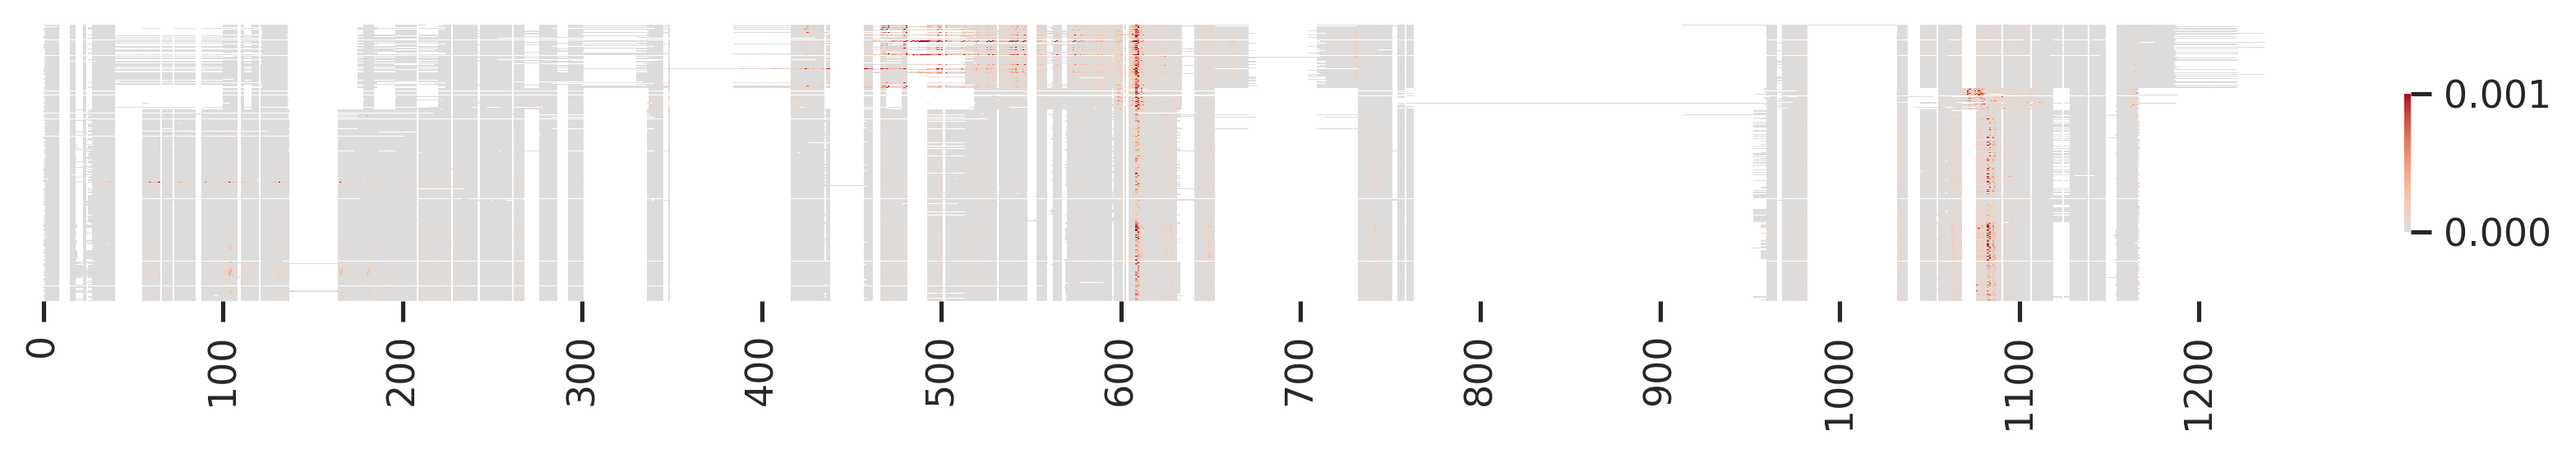

In [31]:

k2v_MapValue={}
for k in list(k2v.keys()):
    map_value=[]
    i=0
    v=R_promoter_TSSsignal[k][0][:,1,:][0]-R_promoter_TSSsignal[k][0][:,0,:][0]
    # v=v/v.max()
    for a in k2v[k]:
        if a == "-":
            map_value.append("na")
        else:
            if i <len(v):
                map_value.append(v[i])
                i=i+1
            else:
                map_value.append(0)
                i=i+1       
    k2v_MapValue[k]=map_value
    # TSS_P.append()
k2v_MapValue=pd.DataFrame.from_dict(k2v_MapValue)
k2v_MapValue.replace('na', np.nan, inplace=True)
k2v_MapValue=k2v_MapValue[ranklist_FC]
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 2)
ax=sns.heatmap(k2v_MapValue.T, center=0, cmap="coolwarm", vmin=0,vmax=0.001,cbar_kws={'shrink': 0.5}, rasterized=True,xticklabels=True, yticklabels=False)##plt.tight_layout()


xticks = list(range(0, k2v_MapValue.T.shape[1], 100))
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)


ax.collections[0].cmap.set_bad('white')
plt.rcParams['pdf.fonttype'] = 42
plt.tight_layout()


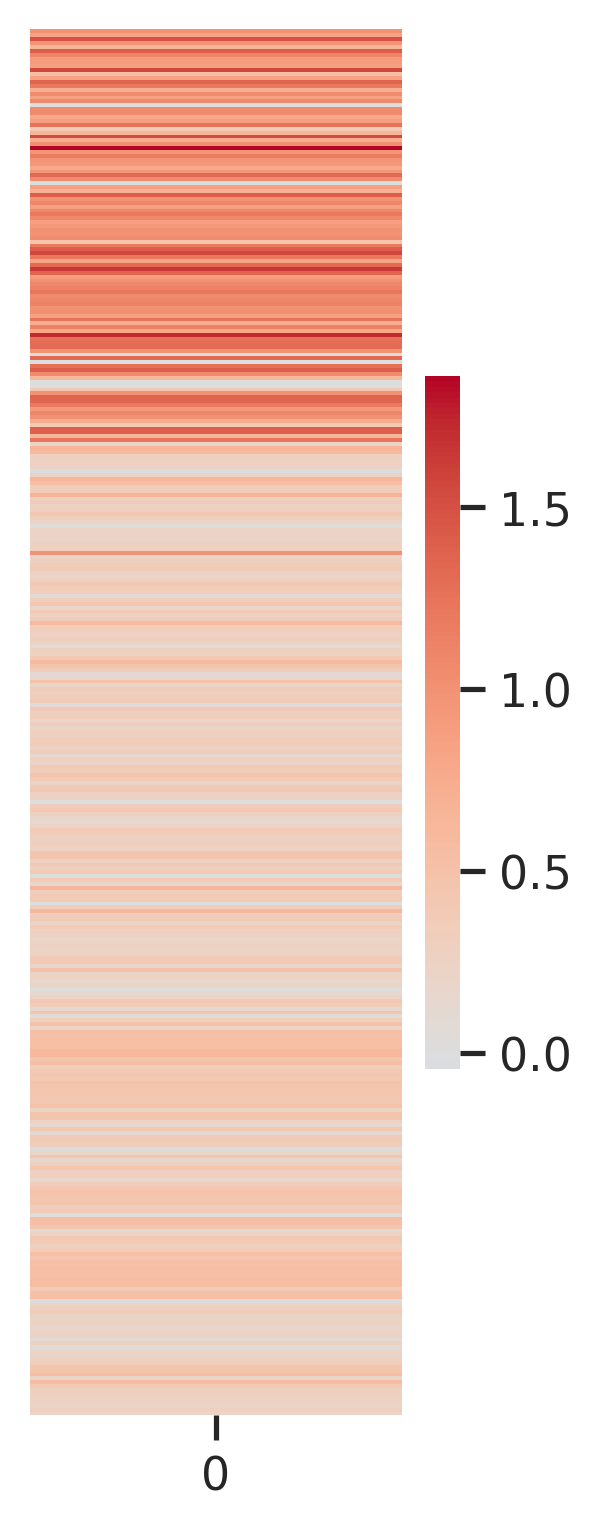

In [32]:
plt.figure(figsize=(2, 6)) 
Diff=np.log2((TSS_S.iloc[:,605:614].sum(1)+0.0001)/(TSS_P.iloc[:,605:614].sum(1)+0.0001))
sns.heatmap(np.array(Diff).reshape(1, -1).T,center=0, cmap="coolwarm",cbar_kws={'shrink': 0.5}, rasterized=True, xticklabels=True, yticklabels=False)##plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42